### Устанавливаем необходимые библиотеки

In [1]:
# %pip install requests
# %pip install pandas
# %pip install numpy
# %pip install keras
# %pip install matplotlib


> 1. Изучить документацию RESTful API Binance (https://binance-docs.github.io/apidocs/spot/en/) и написать скрипт на Python с использованием библиотеки Requests, чтобы получить данные о котировках криптовалют. Сохранить полученные данные в формате CSV.

### Определяем функцию fetch_data для загрузки и сохранения данных о цене криптовалюты с помощью API Binance
Стоит отметить что существует более современный способ с использованием cctx, но сейчас мы придерживаемся задания

In [2]:
# импортирование необходимых библиотек
import os
import re
import math
import csv
import requests

url = 'https://api.binance.com/api/v3/klines'

headers = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

# функция для разбора таймфрейма на составляющие
def parse_timeframe(timeframe):
    time = int(re.findall("[0-9]+", timeframe)[0])
    frame = str(re.findall("[a-zA-Z]+", timeframe)[0])
    if frame == 'm':
        divider = 60 * 1000
    elif frame == 'h':
        divider = 60 * 60 * 1000
    elif frame == 'd':    
        divider = 60 * 60 * 24 * 1000
    return time, divider

# функция для расчета дельты и итераций для определения промежутка времени в миллисекундах
def calculate_delta_and_iterations(start_time_ms, end_time_ms, timeframe):
    time, divider = parse_timeframe(timeframe)
    delta = int((end_time_ms - start_time_ms) / divider / time)
    limit = 1000
    rest = delta % limit
    iterations = [(limit, math.ceil(delta / limit))]
    if rest > 0:
        iterations.append((rest, 1))
    return iterations, time, divider

def fetch_data(symbol, timeframe, start_time_ms, end_time_ms, path='data/'):
    '''
    Функция обходит лимит в 1000 баров
    '''
    if not os.path.exists(path):
        os.makedirs(path)

    iterations, time, divider = calculate_delta_and_iterations(
        start_time_ms, end_time_ms, timeframe)

    whole_data = []
    timestamp = start_time_ms

    for (pack, iterations_count) in iterations:
        for _ in range(iterations_count):
            params = {
                'symbol': symbol,
                'interval': timeframe,
                'startTime': timestamp,
                'limit': pack
            }
            response = requests.get(url, params=params)
            whole_data.extend(response.json())

            timestamp += (divider * pack)

    with open(f'{path}/{symbol.lower()}_{timeframe}_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        for row in whole_data:
            writer.writerow(row[:len(headers)])


### Устанавливаем параметры: временные рамки, время начала и окончания и запускаем функцию получения и сохранения данных

In [3]:
import datetime # модуль для работы с датой и временем

# Начальное и конечное время для получения данных
start_time = "2022-02-10 00:00:00"  # формат: "год-месяц-день час:минута:секунда"
end_time = "2023-03-10 00:00:00"  # формат: "год-месяц-день час:минута:секунда"

# Временной интервал и лимит для получения данных
timeframe = "1h"  # формат: "число + буква, например "1h" для получения данных за 1 час

# Начальное и конечное время в миллисекундах
start_time_ms = int(datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
end_time_ms = int(datetime.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)

# котировка и путь
symbol = 'ATOMUSDT'
path = 'data/'

fetch_data(symbol, timeframe, start_time_ms, end_time_ms)

> 2. Загрузить полученный CSV-файл с данными в Python с использованием библиотеки Pandas и выполнить предварительную обработку данных (например, удаление пропусков, преобразование даты и времени, масштабирование).

### Считываем данные в pandas DataFrame (df), извлекаем столбцы 'open_time' и 'close' и устанавливаем 'open_time' в качестве индекса после преобразования его в формат времени.

In [4]:
import pandas as pd

# загрузка данных из файла CSV в объект DataFrame
# путь к файлу и параметры symbol и timeframe определяются ранее
df = pd.read_csv(f'{path}/{symbol.lower()}_{timeframe}_data.csv')

df = df[['open_time', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'number_of_trades', 'open', 'high', 'low', 'close']]

df["predicted_close"] = df["close"].shift(-4)

df

,open_time,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,number_of_trades,open,high,low,close,predicted_close
0,1644451200000,79166.42,2.420306e+06,33127.13,1.012805e+06,7532,30.910,30.940,30.400,30.430,30.26
1,1644454800000,60120.00,1.824581e+06,30980.79,9.405935e+05,5363,30.440,30.530,30.160,30.400,30.17
2,1644458400000,110625.34,3.356950e+06,65155.87,1.977847e+06,6081,30.400,30.550,30.120,30.150,30.23
3,1644462000000,125149.22,3.777515e+06,71415.06,2.156068e+06,7964,30.140,30.350,30.050,30.260,30.46
4,1644465600000,54178.99,1.637563e+06,26069.17,7.879634e+05,2519,30.260,30.360,30.110,30.260,30.31
...,...,...,...,...,...,...,...,...,...,...,...
10195,1681153200000,54069.98,6.012950e+05,24953.93,2.775346e+05,2264,11.156,11.159,11.086,11.117,11.22
10196,1681156800000,56825.69,6.291313e+05,20316.72,2.249333e+05,2189,11.118,11.129,11.042,11.063,NaN
10197,1681160400000,43771.29,4.852842e+05,25329.23,2.808127e+05,1673,11.064,11.127,11.056,11.127,NaN
10198,1681164000000,110194.84,1.231665e+06,59531.14,6.651971e+05,4287,11.127,11.210,11.127,11.185,NaN


In [5]:
# оставляем только столбцы 'open_time' и 'close'
df = df[['open_time', 'volume','number_of_trades','open','close']].copy()

# преобразуем столбец 'open_time' в объект datetime и устанавливаем его в качестве индекса
df['Date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('Date', inplace=True)

# удаляем столбец 'open_time'
df.drop('open_time', axis=1, inplace=True)

df


,volume,number_of_trades,open,close
Date,,,,
2022-02-10 00:00:00,79166.42,7532,30.910,30.430
2022-02-10 01:00:00,60120.00,5363,30.440,30.400
2022-02-10 02:00:00,110625.34,6081,30.400,30.150
2022-02-10 03:00:00,125149.22,7964,30.140,30.260
2022-02-10 04:00:00,54178.99,2519,30.260,30.260
...,...,...,...,...
2023-04-10 19:00:00,54069.98,2264,11.156,11.117
2023-04-10 20:00:00,56825.69,2189,11.118,11.063
2023-04-10 21:00:00,43771.29,1673,11.064,11.127


In [6]:
original_color = (10 / 256, 10 / 256, 10 / 256)
train_color = (114 / 256, 93 / 256, 191 / 256)
validation_color = (242/ 256, 128 / 256, 18/ 256)
test_color = (47/ 256, 165/ 256, 14/ 256)

<Axes: xlabel='Date'>

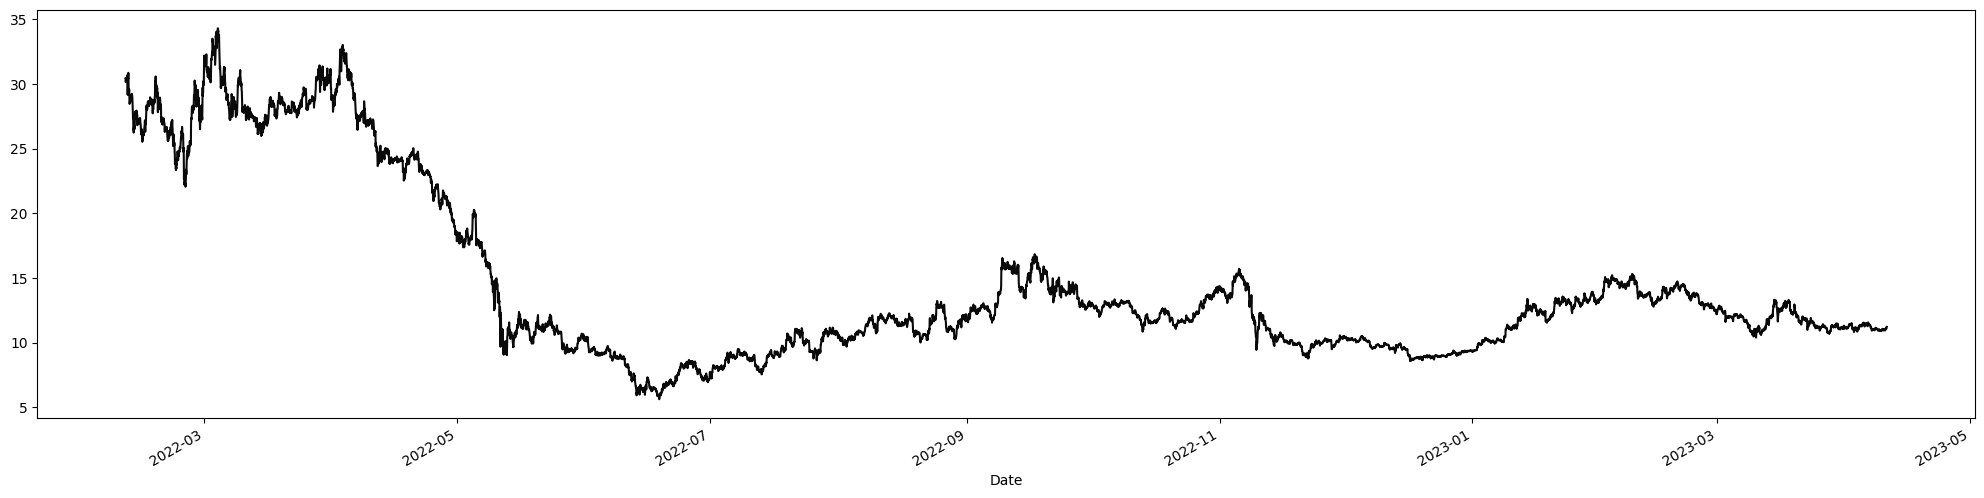

In [7]:
df['close'].plot(figsize=(25,6), color=original_color)

> 3. С использованием библиотеки NumPy, разделить данные на обучающую и тестовую выборки.

### Подготавливаем новый DataFrame (windowed df), добавляя смещенные цены закрытия для создания окна с четырьмя лагами.

### Нормализует DataFrame с помощью MinMaxScaler.

In [8]:
from sklearn.preprocessing import MinMaxScaler

# создаем копию DataFrame
windowed_df = df.copy()

# создаем объект MinMaxScaler для масштабирования данных
scaler = MinMaxScaler()

# масштабируем DataFrame и создаем новый DataFrame с масштабированными данными
scaled_df = scaler.fit_transform(windowed_df)
windowed_df = pd.DataFrame(scaled_df, columns=windowed_df.columns, index=windowed_df.index)

# добавляем новые столбцы 'target_a', 'target_b', 'target_c', 'target_d'
# значения цены закрытия сдвинуты на -1, -2, -3 и -4 строки соответственно
windowed_df['volume'] = windowed_df['volume'].shift(1)
windowed_df['number_of_trades'] = windowed_df['number_of_trades'].shift(1)
windowed_df['open'] = windowed_df['open'].shift(1)

windowed_df.insert(4, 'target_close', windowed_df['close'])
windowed_df['close'] = windowed_df['close'].shift(1)

windowed_df

,volume,number_of_trades,open,close,target_close
Date,,,,,
2022-02-10 00:00:00,NaN,NaN,NaN,NaN,0.865016
2022-02-10 01:00:00,0.033026,0.066778,0.881758,0.865016,0.863969
2022-02-10 02:00:00,0.025081,0.047548,0.865364,0.863969,0.855249
2022-02-10 03:00:00,0.046150,0.053914,0.863969,0.855249,0.859086
2022-02-10 04:00:00,0.052209,0.070608,0.854901,0.859086,0.859086
...,...,...,...,...,...
2023-04-10 19:00:00,0.061153,0.049880,0.191141,0.192745,0.191385
2023-04-10 20:00:00,0.022557,0.020073,0.192745,0.191385,0.189501
2023-04-10 21:00:00,0.023706,0.019408,0.191420,0.189501,0.191734


In [9]:
import numpy as np


# сбрасываем индекс DataFrame и устанавливаем 'target_date' в качетсве индекса
windowed_df.reset_index(inplace=True, names='target_date')


In [10]:
# оставляем только последние n строк DataFrame
n = 3000
windowed_df = windowed_df[-n:]

# функция для преобразования DataFrame в кортеж из дат, признаков и целевых значений
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

# применяем функцию windowed_df_to_date_X_y к объекту DataFrame и сохраняем результат в переменные dates, X и y
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# выводим размерности массивов dates, X и y
dates.shape, X.shape, y.shape


((3000,), (3000, 4, 1), (3000,))

### Разделение данных на обучающий, проверочный и тестовый наборы на основе соотношения 80-10-10.

ValueError: non-broadcastable output operand with shape (2400,1) doesn't match the broadcast shape (2400,4)

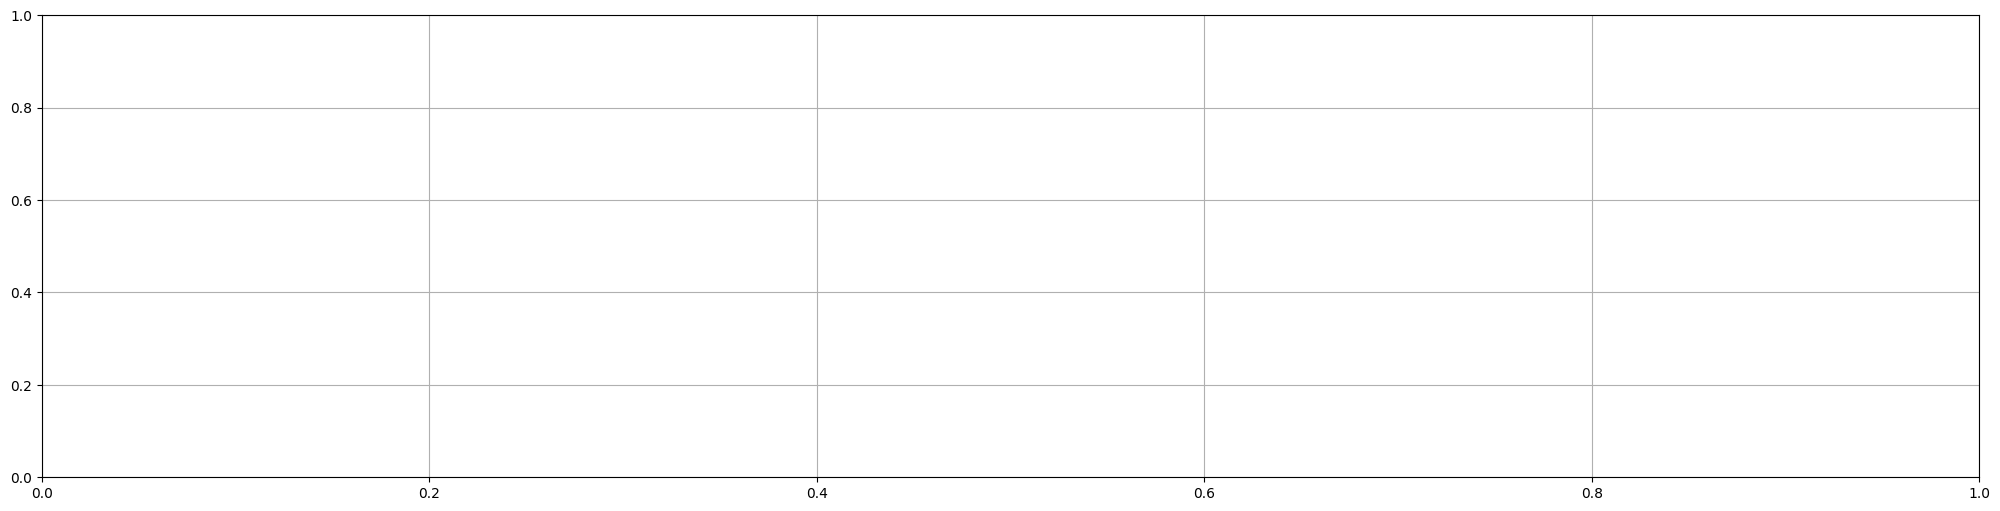

In [11]:
# Импорт библиотеки для построения графиков
import matplotlib.pyplot as plt

# Вычисление индексов для разбиения данных на тренировочную, валидационную и тестовую выборки
q_80 = int(len(dates) * .8) # 80% данных для тренировки
q_90 = int(len(dates) * .9) # 10% данных для валидации и 10% для тестирования

# Разбиение данных на тренировочную выборку
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# Разбиение данных на валидационную выборку
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# Разбиение данных на тестовую выборку
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Настройка размера графика
plt.figure(figsize=(25,6))
plt.grid()
# Построение графиков для тренировочной, валидационной и тестовой выборок
plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)), color=train_color)
plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)), color=validation_color)
plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)), color=test_color)

# Добавление легенды к графику
plt.legend(['Train', 'Validation', 'Test'])


> 4. Создать и обучить LSTM-модель с использованием библиотеки Keras или TensorFlow на основе подготовленных данных. Подобрать архитектуру и гиперпараметры модели, чтобы достичь наилучшего качества прогнозирования.

> 5. Оценить качество модели на тестовой выборке, используя подходящие метрики, такие как среднеквадратичная ошибка (MSE) или средняя абсолютная ошибка (MAE).


### Загружаем необходимые библиотеки и подготавливаем модель

In [ ]:
# Импорт необходимых модулей из библиотеки TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Создание последовательной модели
model = Sequential([layers.Input((4, 1)), # Входной слой с размерностью входных данных (4, 1)
                    layers.LSTM(64), # Скрытый слой LSTM с 64 нейронами
                    layers.Dense(32, activation='relu'), # Полносвязный слой с 32 нейронами и функцией активации ReLU
                    layers.Dense(32, activation='relu'), # Полносвязный слой с 32 нейронами и функцией активации ReLU
                    layers.Dense(1)]) # Выходной слой с одним нейроном

# Компиляция модели
model.compile(loss='mse', # Функция потерь - среднеквадратичная ошибка
              optimizer=Adam(learning_rate=0.001), # Оптимизатор Adam с заданным коэффициентом обучения
              metrics=['mean_absolute_error']) # Метрика качества модели - средняя абсолютная ошибка

# Обучение модели на тренировочных данных
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

models_path = 'models/'

if not os.path.exists(models_path):
    os.makedirs(models_path)

model.save(f'{models_path}{symbol}.h5')


> 6. Визуализировать предсказания модели для тестовой выборки на графике с помощью библиотеки Matplotlib или Plotly. Вывести график с предсказанием на час вперед от последних полученных данных.


In [ ]:
# Получение предсказаний модели на тренировочных данных
train_predictions = model.predict(X_train).flatten()

# Визуализация предсказаний модели и фактических значений на тренировочных данных
plt.figure(figsize=(25,6))
plt.grid()

plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)), color=original_color, linewidth=0.5) # График фактических значений
plt.plot(dates_train, scaler.inverse_transform(train_predictions.reshape(-1, 1)), color=train_color, linewidth=2) # График предсказаний
plt.legend(['Training Observations','Training Predictions']) # Наименование графиков в легенде


In [ ]:
# Получение предсказаний модели на вадидационных данных
val_predictions = model.predict(X_val).flatten()

# Визуализация предсказаний модели и фактических значений
plt.figure(figsize=(25,6))
plt.grid()
plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)), color=original_color, linewidth=0.5)
plt.plot(dates_val, scaler.inverse_transform(val_predictions.reshape(-1, 1)), color=validation_color, linewidth=2)

plt.legend(['Validation Observations','Validation Predictions'])

In [ ]:
# Получение предсказаний модели на тестовых данных
test_predictions = model.predict(X_test).flatten()

# scaler.inverse_transform(test_predictions.reshape(-1, 5))

# Визуализация предсказаний модели и фактических значений на тестовых данных
plt.figure(figsize=(25,6))
plt.grid()

plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)), color=original_color, linewidth=0.5) # График фактических значений
plt.plot(dates_test, scaler.inverse_transform(test_predictions.reshape(-1, 1)), color=test_color, linewidth=2) # График предсказаний
plt.legend(['Testing Observations', 'Testing Predictions']) # Наименование графиков в легенде

In [ ]:
X_test[-4:,0]

In [ ]:
y_test.reshape(-1, 1)[-3:]

In [ ]:
plt.figure(figsize=(25,6))
plt.grid()
plt.plot(df.index[-n:], df[-n:], color=original_color, linewidth=0.5) 
plt.plot(dates_train, scaler.inverse_transform(train_predictions.reshape(-1, 1)), color=train_color, linewidth=2)

plt.plot(dates_val, scaler.inverse_transform(val_predictions.reshape(-1, 1)), color=validation_color, linewidth=2)

plt.plot(dates_test, scaler.inverse_transform(test_predictions.reshape(-1, 1)), color=test_color, linewidth=2)



plt.legend(['Real Price',
            'Training Predictions', 

            'Validation Predictions', 

            'Testing Predictions', 

            ])
